In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.signal import convolve2d

#import models
#import tensorflow as tf
#from tensorflow.keras import Input, Model
from skimage.draw import line
import imageio as io

In [2]:
def Motion_blur_kernel(r, angle):
    #Get the size of the Kernel
    if angle != 0 and abs(angle) != 90:
        width = int(np.ceil(np.abs(r * np.sin(angle*np.pi/180))))
        height = int(np.ceil(np.abs(r * np.cos(angle*np.pi/180))))

        if width == 0:
            width = 1
        if height == 0:
            height = 1
            
        # Define a zero sized Kernel
        K = np.zeros((width,height))
        x_max, y_max = K.shape
        #Define direction of line and special cases
        if angle < 0:
            x_start, y_start, x_stop, y_stop = [0,0,x_max-1,y_max-1]
        else:
            x_start, y_start, x_stop, y_stop = [x_max-1, 0, 0, y_max-1]
        #Draw Line
        rr, cc = line(x_start, y_start, x_stop, y_stop)
        try: K[rr,cc] = 1
        except:
            #plt.imshow(K)
            print(width,height)
            print("Max",x_max,y_max)
            print("Coordinates are ({},{}), ({},{})".format(x_start, y_start, x_stop, y_stop))
        K = K/K.sum()
        n_angle = np.arctan(width/height) * 180 /np.pi
        n_r = np.sqrt(height**2 + width**2)

        if angle < 0:
            n_angle *= -1

    #Special case angle 0    
    if angle == 0:
        K = np.ones((1,r))
        K = K/K.sum()
        n_angle = angle
        n_r = r

    #Special case angle 90 or -90
    if abs(angle) == 90:
        K = np.ones((r,1))
        K = K/K.sum()
        n_angle = angle
        n_r = r
    
    return(K)

## Medium Turbulence

In [ ]:
I = mpimg.imread('4_med.png')
I = I[:,:,0:3]
plt.imshow(I,cmap='gray')
plt.axis('off')
io.imwrite('Blur_Fields/med_img.png', I)
plt.show()
print(I.shape)

In [ ]:
model = models.model_v5()
model.load_weights('Weights/Weights_V8.h5')



In [ ]:
def Blur_Field(I, PATCH_SIZE):
    field = np.zeros((I.shape[0], I.shape[1]))
    
    for i in range(0,I.shape[0], PATCH_SIZE):
        if i + PATCH_SIZE > I.shape[0]:
            break
        else:

            for j in range(0, I.shape[1], PATCH_SIZE):
                if j + PATCH_SIZE > I.shape[1]:
                    break
                else:
                    # grab patch 
                    I_patch = I[i:i+PATCH_SIZE,j:j+PATCH_SIZE,0:3]
                    I_patch = np.expand_dims(I_patch, 0)

                    #detection
                    pred = model.predict(I_patch)
                    #denormalize
                    length = (100 - 1)*pred[0,0] + 1
                    angle = (90 - (-90))*pred[0,1] + (-90)

                    # create blur kernel
                    K = Motion_blur_kernel(length,angle)

                    if K.shape[0] > PATCH_SIZE:
                        Starti = i
                        Endi = i + PATCH_SIZE
                        K = K[:PATCH_SIZE,:]
                    else:
                        Starti = i + (PATCH_SIZE - K.shape[0])//2 
                        Endi = Starti + K.shape[0]

                    if K.shape[1] > PATCH_SIZE:
                        Startj = j
                        Endj = j + PATCH_SIZE
                        K = K[:,:PATCH_SIZE]
                    else:
                        Startj = j + (PATCH_SIZE - K.shape[1]) // 2
                        Endj = Startj + K.shape[1]


                    # attach to an empty image
                    field[Starti:Endi,Startj:Endj] = K
    return field

In [2]:
for patch in [224, 112, 64, 32]:
    field = Blur_Field(I, patch)
    field[field>0] = 255
    #plt.imshow(field, cmap='gray')
    #plt.axis('off')
    io.imsave('Blur_Fields/med_'+str(patch)+'.png', field)

field = Blur_Field(I,32)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(I,64)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(I, 112)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(I, 224)
plt.figure()
plt.imshow(field, cmap='gray')

NameError: name 'Blur_Field' is not defined

## Low Turbulence

In [3]:
I = mpimg.imread('4_low.png')
I = I[:,:,0:3]
plt.imshow(I,cmap='gray')
plt.axis('off')
io.imwrite('Blur_Fields/low_img.png', I)
plt.show()
print(I.shape)

FileNotFoundError: [Errno 2] No such file or directory: '4_low.png'

In [ ]:
for patch in [224, 112, 64, 32]:
    field = Blur_Field(I, patch)
    field[field>0] = 255
    plt.imshow(field, cmap='gray')
    plt.axis('off')
    io.imwrite('Blur_Fields/low_'+str(patch)+'.png', field)

field = Blur_Field(I,32)
plt.figure()
field[field>0] = 255
plt.imshow(field, cmap='gray')

field = Blur_Field(I,64)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(I, 112)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(I, 224)
plt.figure()
plt.imshow(field, cmap='gray')

## Circular Blur

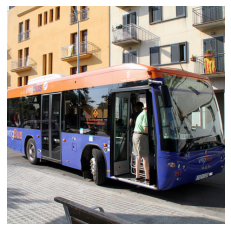

(426, 426, 3)


In [7]:
coco_dir = 'COCO_val2014_'
filename = '000000387082.jpg'

I = mpimg.imread(coco_dir + filename)
start = (I.shape[1] - I.shape[0]) // 2
I = I[:,start:start+I.shape[0],:]
I = I[:-1,:-1,:] / 255.0
plt.imshow(I)
plt.axis('off')
plt.show()
print(I.shape)

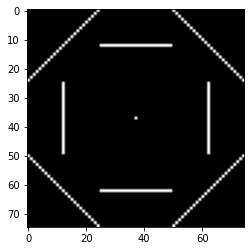

In [5]:
M = 25 # filter length

h1 = np.flipud(np.diag(np.ones(M)))/M #upward diagonal
h2 = np.zeros((M,M))
h2[M//2,:] = 1/M #horizontal
h3 = np.diag(np.ones(M))/M #downward diagonal
h4 = np.zeros((M,M))
h4[:,M//2] = 1/M   #Vertical
h5 = np.zeros((M,M))
h5[M//2,M//2] = 1   #Identity 
h6 = h4  #Vertical
h7 = h3  
h8 = h2
h9 = h1

p1 = np.concatenate([h1,h2,h3], axis=1)
p2 = np.concatenate([h4,h5,h6], axis=1)
p3 = np.concatenate([h7,h8,h9], axis=1)
H = np.concatenate([p1,p2,p3], axis=0)
H[H>0] = 255
plt.imshow(H, 'gray')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


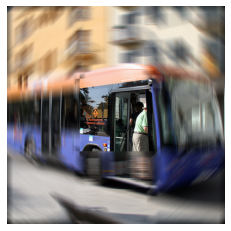

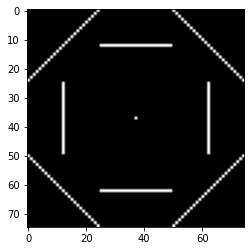

In [8]:
L = int(I.shape[0])
M = int(h1.shape[0])-1

J = np.zeros((L+M,L+M, 3))

L = int(L/3)
for i in range(0,3):
    J[0:L+M,0:L+M,i] += convolve2d(I[0:L,0:L,i],h1,mode='full')
    J[0:L+M,L:L+(L+M),i] += convolve2d(I[0:L,L:L*2,i],h2,mode='full')
    J[0:L+M,L*2:L*2+(L+M),i] += convolve2d(I[0:L,L*2:,i],h3,mode='full')
    J[L:L+(L+M),0:L+M,i] += convolve2d(I[L:L*2,0:L,i],h4,mode='full')
    J[L:L+(L+M),L:L+(L+M),i] += convolve2d(I[L:L*2,L:L*2,i],h5,mode='full')
    J[L:L+(L+M),L*2:L*2+(L+M),i] += convolve2d(I[L:L*2,L*2:,i],h6,mode='full')
    J[L*2:,0:L+M,i] += convolve2d(I[L*2:,0:L,i],h7,mode='full')
    J[L*2:,L:L+(L+M),i] += convolve2d(I[L*2:,L:L*2,i],h8,mode='full')
    J[L*2:,2*L:,i] += convolve2d(I[L*2:,2*L:,i],h9,mode='full')

J = J[12:-12,12:-12,:]
plt.imshow((J*255).astype('uint8'),cmap='gray')
plt.axis('off')
io.imwrite('Blur_Fields/circular_img.png',(J*255).astype('uint8'))
io.imwrite('Blur_Fields/circular_map.png', H)
plt.figure()
plt.imshow(H, 'gray')

In [6]:
for patch in [213, 112, 64, 32]:
    field = Blur_Field(J, patch)
    field[field>0] = 255
    plt.imshow(field, cmap='gray')
    plt.axis('off')
    io.imwrite('Blur_Fields/circular_'+str(patch)+'.png', field)

field = Blur_Field(J,32)
plt.figure()
field[field>0] = 255
plt.imshow(field, cmap='gray')

field = Blur_Field(J,64)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 112)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 224)
plt.figure()
plt.imshow(field, cmap='gray')

NameError: name 'Blur_Field' is not defined

## Changing Lengths

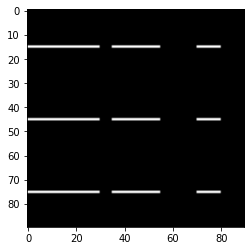

In [9]:
M = 30 # filter length

h1 = np.zeros((M,M))
h1[M//2,:] = 1/M #horizontal
h2 = np.zeros((M,M))
h2[M//2,5:25] = 1/(25-5)
h3 = np.zeros((M,M))
h3[M//2,10:20] = 1/(20-10)
h4 = h1
h5 = h2
h6 = h3
h7 = h1
h8 = h2
h9 = h3

p1 = np.concatenate([h1,h2,h3], axis=1)
p2 = np.concatenate([h4,h5,h6], axis=1)
p3 = np.concatenate([h7,h8,h9], axis=1)
H = np.concatenate([p1,p2,p3], axis=0)
H[H>0] = 255
plt.imshow(H, 'gray')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


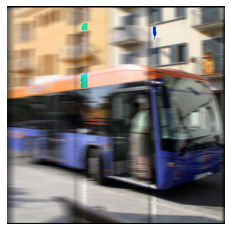

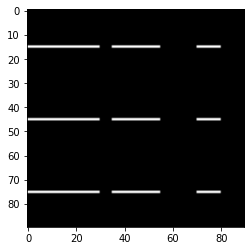

In [10]:
L = int(I.shape[0])
M = int(h1.shape[0])-1

J = np.zeros((L+M,L+M, 3))

L = int(L/3)
for i in range(0,3):
    J[0:L+M,0:L+M,i] += convolve2d(I[0:L,0:L,i],h1,mode='full')
    J[0:L+M,L:L+(L+M),i] += convolve2d(I[0:L,L:L*2,i],h2,mode='full')
    J[0:L+M,L*2:L*2+(L+M),i] += convolve2d(I[0:L,L*2:,i],h3,mode='full')
    J[L:L+(L+M),0:L+M,i] += convolve2d(I[L:L*2,0:L,i],h4,mode='full')
    J[L:L+(L+M),L:L+(L+M),i] += convolve2d(I[L:L*2,L:L*2,i],h5,mode='full')
    J[L:L+(L+M),L*2:L*2+(L+M),i] += convolve2d(I[L:L*2,L*2:,i],h6,mode='full')
    J[L*2:,0:L+M,i] += convolve2d(I[L*2:,0:L,i],h7,mode='full')
    J[L*2:,L:L+(L+M),i] += convolve2d(I[L*2:,L:L*2,i],h8,mode='full')
    J[L*2:,2*L:,i] += convolve2d(I[L*2:,2*L:,i],h9,mode='full')

J = J[12:-12,12:-12,:]
plt.imshow((J*255).astype('uint8'),cmap='gray')
plt.axis('off')
io.imsave('Blur_Fields/chlength_img.png',(J*255).astype('uint8'))
io.imsave('Blur_Fields/chlength_map.png', H)
plt.figure()

plt.imshow(H, 'gray')

In [ ]:
for patch in [213, 112, 64, 32]:
    field = Blur_Field(J, patch)
    field[field>0] = 255
    plt.imshow(field, cmap='gray')
    plt.axis('off')
    io.imwrite('Blur_Fields/chlength_'+str(patch)+'.png', field)

field = Blur_Field(J,32)
plt.figure()
field[field>0] = 255
plt.imshow(field, cmap='gray')

field = Blur_Field(J,64)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 112)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 224)
plt.figure()
plt.imshow(field, cmap='gray')

## Horizontal to Vertical

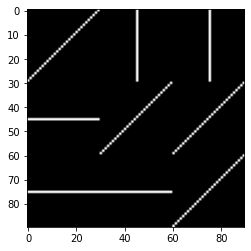

In [11]:
M = 30 # filter length


h1 = np.flipud(np.diag(np.ones(M)))/M #upward diagonal
h2 = np.zeros((M,M))
h2[:,M//2] = 1/M   #Vertical
h3 = h2
h4 = np.zeros((M,M))
h4[M//2,:] = 1/M #horizontal
h5 = h1
h6 = h1
h7 = h4
h8 = h4
h9 = h1

p1 = np.concatenate([h1,h2,h3], axis=1)
p2 = np.concatenate([h4,h5,h6], axis=1)
p3 = np.concatenate([h7,h8,h9], axis=1)
H = np.concatenate([p1,p2,p3], axis=0)
H[H>0] = 255
plt.imshow(H, 'gray')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


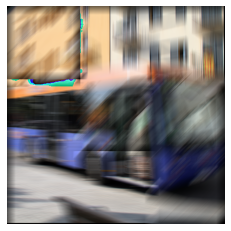

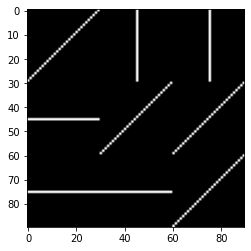

In [12]:
L = int(I.shape[0])
M = int(h1.shape[0])-1

J = np.zeros((L+M,L+M, 3))

L = int(L/3)
for i in range(0,3):
    J[0:L+M,0:L+M,i] += convolve2d(I[0:L,0:L,i],h1,mode='full')
    J[0:L+M,L:L+(L+M),i] += convolve2d(I[0:L,L:L*2,i],h2,mode='full')
    J[0:L+M,L*2:L*2+(L+M),i] += convolve2d(I[0:L,L*2:,i],h3,mode='full')
    J[L:L+(L+M),0:L+M,i] += convolve2d(I[L:L*2,0:L,i],h4,mode='full')
    J[L:L+(L+M),L:L+(L+M),i] += convolve2d(I[L:L*2,L:L*2,i],h5,mode='full')
    J[L:L+(L+M),L*2:L*2+(L+M),i] += convolve2d(I[L:L*2,L*2:,i],h6,mode='full')
    J[L*2:,0:L+M,i] += convolve2d(I[L*2:,0:L,i],h7,mode='full')
    J[L*2:,L:L+(L+M),i] += convolve2d(I[L*2:,L:L*2,i],h8,mode='full')
    J[L*2:,2*L:,i] += convolve2d(I[L*2:,2*L:,i],h9,mode='full')

J = J[12:-12,12:-12,:]
plt.imshow((J*255).astype('uint8'),cmap='gray')
plt.axis('off')
io.imwrite('Blur_Fields/htv_img.png',(J*255).astype('uint8'))
io.imwrite('Blur_Fields/htv_map.png', H)
plt.figure()

plt.imshow(H, 'gray')

In [ ]:
for patch in [213, 112, 64, 32]:
    field = Blur_Field(J, patch)
    field[field>0] = 255
    plt.imshow(field, cmap='gray')
    plt.axis('off')
    io.imwrite('Blur_Fields/htv_'+str(patch)+'.png', field)

field = Blur_Field(J,32)
plt.figure()
field[field>0] = 255
plt.imshow(field, cmap='gray')

field = Blur_Field(J,64)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 112)
plt.figure()
plt.imshow(field, cmap='gray')

field = Blur_Field(J, 224)
plt.figure()
plt.imshow(field, cmap='gray')